In [1]:
import os
import glob
from pathlib import Path
import ssl
import random
from datetime import datetime
import time
import gc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from skimage.util import random_noise

import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.utils import make_grid

import torch.nn as nn
from torch import flatten


# if using remote server
current_path = os.path.basename(os.path.normpath(os.getcwd()))
DIR = "digit-denoiser"
if(current_path != DIR):
	os.chdir(DIR)
	print("Changed directory into: "+DIR)

BATCH_SIZE = 128
SHUFFLE = True
NUM_WORKERS = 0
PIN_MEMORY = True

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device == "cuda:0":
	print(device, torch.cuda.get_device_name(0))
else:
	print(device)

C:\Users\alex\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Changed directory into: digit-denoiser
cuda:0


In [2]:
# get dataset
train_ds = datasets.MNIST(
	root="data",
	train=True,
	download=True,
)

val_ds = datasets.MNIST(
	root="data",
	train=False,
	download=True,
)

train_images = train_ds.data.numpy()
train_labels = train_ds.targets.numpy()

val_images = val_ds.data.numpy()
val_labels = val_ds.targets.numpy()

In [3]:
# image loader
class PreAugmentDataset(Dataset):
	def __init__(self, images, labels, transform=None):
		self.transform = transform
		self.images = images.copy()
		self.labels = labels.copy()

		self.images = np.expand_dims(self.images,1) # make format (size, channels, width, height)

		self.images = torch.tensor(self.images / 255., dtype=torch.float32) # to tensor
		self.images = torch.clamp(self.images, 0., 1.) # clamp between 0 and 1

		self.labels = torch.tensor(self.labels) # to tensor

		print(self.images.shape)

	def applyTransforms(self):

		self.original_images = self.images.clone()

		# salt and pepper noise
		level_of_noise = 0.5
		self.images = self.images + torch.randn(self.images.size()) * level_of_noise
		
		self.images = torch.clamp(self.images, 0., 1.).type(torch.float32)

	def __len__(self):
		return len(self.labels)

	def __getitem__(self, idx):
		image = self.images[idx]
		original_image = self.original_images[idx]
		label = self.labels[idx]
		return image, original_image, label
		

train_ds = PreAugmentDataset(train_images, train_labels)
val_ds = PreAugmentDataset(val_images, val_labels)

train_loader = torch.utils.data.DataLoader(
	train_ds, 
	batch_size = BATCH_SIZE, 
	shuffle = SHUFFLE, 
	num_workers=NUM_WORKERS, 
	pin_memory=PIN_MEMORY
)
val_loader = torch.utils.data.DataLoader(
	val_ds, 
	batch_size = BATCH_SIZE, 
	shuffle = SHUFFLE, 
	num_workers=NUM_WORKERS, 
	pin_memory=PIN_MEMORY
)

print('Training set has {} instances'.format(len(train_ds)))
print('Validation set has {} instances'.format(len(val_ds)))

torch.Size([60000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])
Training set has 60000 instances
Validation set has 10000 instances


In [4]:
# image transformations

train_ds.applyTransforms()
print("train_ds done")
val_ds.applyTransforms()
print("val_ds done")

train_ds done
val_ds done


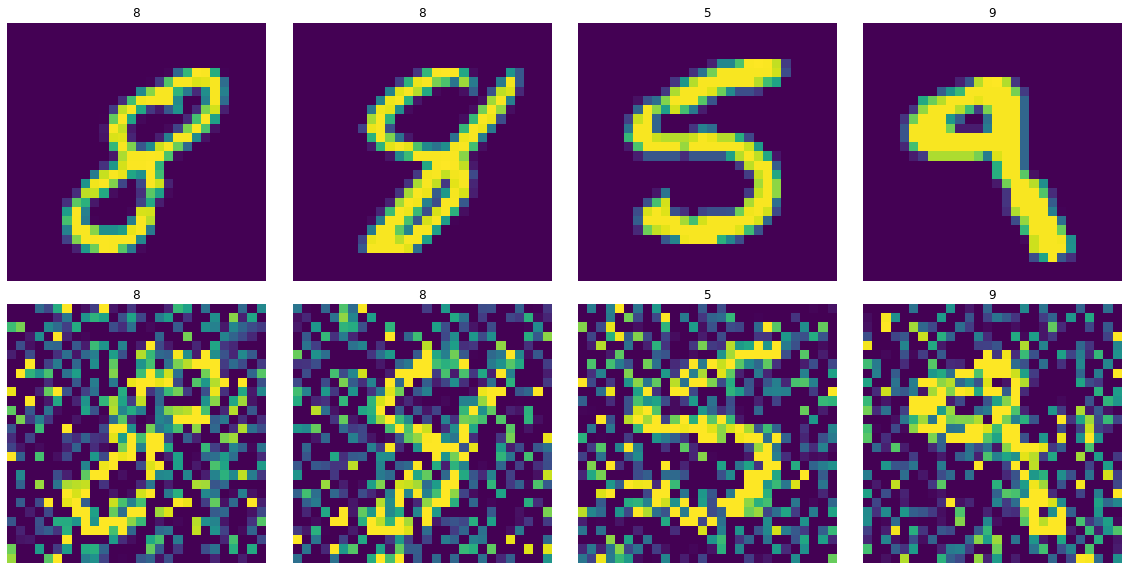

In [5]:
# plot images
fig, axes = plt.subplots(2,4, figsize=(16, 8))

first_batch = next(iter(train_loader))
images = first_batch[0]
original_images = first_batch[1]
labels = first_batch[2]

for i, ax in enumerate(axes.flat):
	if(i < 4):
		image = original_images[i]
	else:
		image = images[i%4]
	ax.imshow(image.squeeze())
	ax.set_title(labels[i%4].item())
	ax.axis("off")

plt.tight_layout()
plt.show()

In [6]:
# create model
class ClassifierModel(nn.Module):
	def __init__(self, shape):
		super(ClassifierModel, self).__init__()
		
		self.shape = shape
		size = shape[1]*shape[2]

		#--- Encoder Layer
		self.encode_block = nn.Sequential(
			nn.Linear(in_features=size, out_features=size),
			nn.BatchNorm1d(1),
			nn.LeakyReLU()
		)

		#--- Middle Layer
		self.middle_block = nn.Linear(in_features=size, out_features=size)

		#--- Decoder Layer
		self.decode_block = nn.Sequential(
			nn.Linear(in_features=size, out_features=size),
			nn.BatchNorm1d(1),
			nn.LeakyReLU()
		)

		self.output_block = nn.Sequential( # fully connect
			nn.Linear(in_features=size, out_features=size),
			nn.Sigmoid()
		)

	def forward(self, x):
		#x = flatten(x, 1)
		x = x.view(-1, self.shape[0], self.shape[1]*self.shape[2]) # resize to [128, 1, 784]
		x = self.encode_block(x)
		x = self.middle_block(x)
		x = self.decode_block(x)
		output = self.output_block(x)
		output = output.view(-1, self.shape[0], self.shape[1], self.shape[2])
		return output

	def training_step(self, batch):
		images = batch[0].to(device, non_blocking=True)
		original_images = batch[1].to(device, non_blocking=True)
		self.optimizer.zero_grad()
		out = self(images)
		loss = self.criterion(out, original_images)
		loss.backward()
		self.optimizer.step()
	
	def validation_step(self, batch):
		images = batch[0].to(device, non_blocking=True)
		original_images = batch[1].to(device, non_blocking=True) # match prediction size
		out = self(images)
		loss = self.criterion(out, original_images)
		return {'val_loss': loss}
		
	def validation_epoch_end(self, outputs):
		batch_losses = [x['val_loss'] for x in outputs]
		epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
		return {'val_loss': epoch_loss.item()}
	
	def epoch_end(self, epoch, result, ttime=0, vtime=0):
		print("Epoch [{}]: train time: {:.1f}s, val time: {:.1f}s, val_loss: {:.3f}".format(epoch+1, ttime, vtime, result['val_loss']*100))

In [7]:
def evaluate(model, val_loader):
	with torch.no_grad():
		outputs = [model.validation_step(batch) for batch in val_loader]
		return model.validation_epoch_end(outputs)


def fit(epochs, model, train_loader, val_loader):
	history = []
	for epoch in range(epochs):
		t0 = time.time()

		# Training Phase 
		model.train()
		for b, batch in enumerate(train_loader):
			model.training_step(batch)
			
			if b % 10 == 0:
				print(f'{b}/{len(train_loader)}', end="\r")
		t1 = time.time()

		# Validation phase
		with torch.no_grad():
			model.eval()
			result = evaluate(model, val_loader)
			model.epoch_end(epoch, result, (t1 - t0), (time.time() - t1))
			history.append(result)
	return history

In [8]:
# Model (on GPU)
model = ClassifierModel(image.shape)

model.to(device, non_blocking=True)
model.optimizer = torch.optim.Adam(model.parameters(), 0.0001) # lr
model.criterion = nn.MSELoss()

# test validation dataset
history = [evaluate(model, val_loader)]
history

[{'val_loss': 0.23978354036808014}]

In [9]:
history += fit(25, model, train_loader, val_loader)

Epoch [1]: train time: 2.0s, val time: 0.1s, val_loss: 2.814
Epoch [2]: train time: 1.9s, val time: 0.1s, val_loss: 1.958
Epoch [3]: train time: 2.0s, val time: 0.1s, val_loss: 1.669
Epoch [4]: train time: 2.0s, val time: 0.1s, val_loss: 1.530
Epoch [5]: train time: 2.0s, val time: 0.1s, val_loss: 1.454
Epoch [6]: train time: 1.9s, val time: 0.1s, val_loss: 1.395
Epoch [7]: train time: 2.0s, val time: 0.1s, val_loss: 1.348
Epoch [8]: train time: 2.0s, val time: 0.1s, val_loss: 1.319
Epoch [9]: train time: 2.0s, val time: 0.1s, val_loss: 1.294
Epoch [10]: train time: 2.0s, val time: 0.1s, val_loss: 1.272
Epoch [11]: train time: 1.9s, val time: 0.1s, val_loss: 1.264
Epoch [12]: train time: 2.0s, val time: 0.1s, val_loss: 1.248
Epoch [13]: train time: 2.0s, val time: 0.1s, val_loss: 1.249
Epoch [14]: train time: 1.9s, val time: 0.1s, val_loss: 1.237
Epoch [15]: train time: 2.0s, val time: 0.1s, val_loss: 1.236
Epoch [16]: train time: 2.0s, val time: 0.1s, val_loss: 1.226
Epoch [17]: train

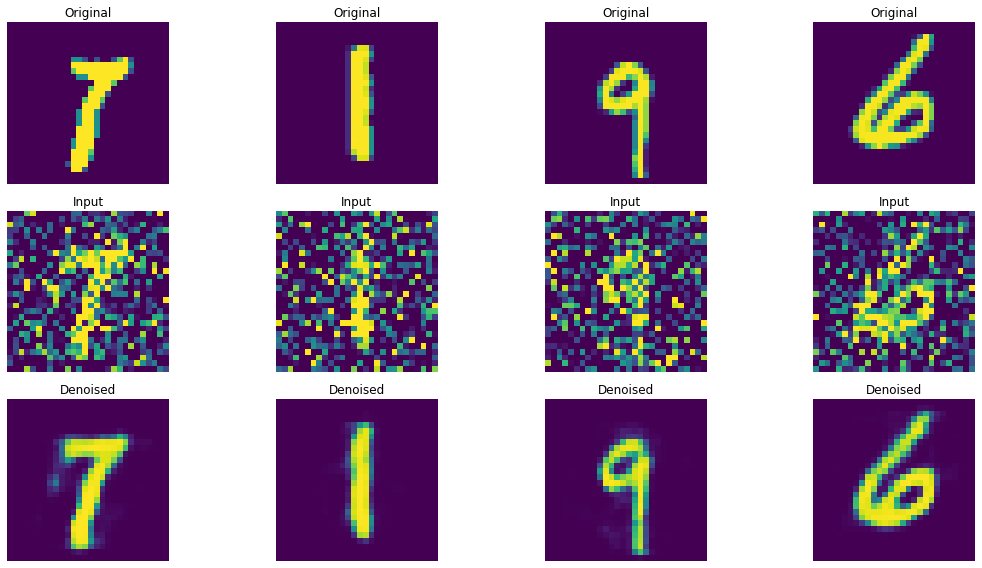

In [10]:
# plot images
fig, axes = plt.subplots(3,4, figsize=(16, 8))

# enable evaluation mode
model.eval()

# get data
first_batch = next(iter(train_loader))
images = first_batch[0][0:4]
original_images = first_batch[1][0:4]
labels = first_batch[2][0:4]

with torch.no_grad():

	for i, ax in enumerate(axes.flat):
		if(i < 4):
			ax.set_title("Original")
			image = original_images[i%4]
		elif(i >= 4 and i < 8):
			ax.set_title("Input")
			image = images[i%4]
		else:
			ax.set_title("Denoised")
			input_image = images[i%4].to(device)
			image = model(input_image)
			image = image.cpu()
		ax.imshow(image.clamp(0,1).squeeze())
		#ax.set_title(labels[i%4].item())
		ax.axis("off")

	plt.tight_layout()
	plt.show()

In [11]:
f_history = {"val_loss": [], "val_acc": []}
for epoch in history:
	f_history['val_loss'].append(epoch['val_loss'])
	#f_history['val_acc'].append(epoch['val_acc'])
history = f_history

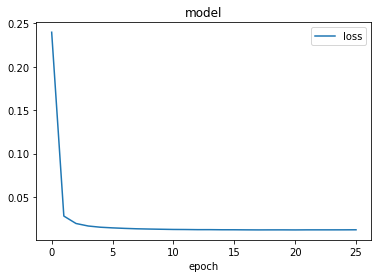

In [12]:
#plt.plot(history['val_acc'])
plt.plot(history['val_loss'])
plt.title('model')
#plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.ylim([0,1])
plt.legend(['loss'], loc='best')
plt.show()

In [13]:
# del model
# torch.cuda.synchronize()
# torch.cuda.empty_cache()
# gc.collect()